# Predicting School Closures Based on Inspection Reports with Deep Learning
We scraped school inspection reports from [Ofsted](https://reports.ofsted.gov.uk) in an attempt to predict whether or not a school is in danger of closing. In this notebook, we take a deep learning approach to a Natural Language Processing (NLP) problem. This notebook applies [fast.ai's transfer learning](https://www.fast.ai/2019/07/08/fastai-nlp/) approach by training a language model (we'll get into what that is soon) on a large corpus of school reports. This model is then used to help our classifier predict whether or not a report contains some indication that the school will close.

The logic behind our approach was to separate all of the final reports of schools that have already closed. The idea behind this was that these reports may contain some information as to why the school would close. We labeled these reports `last`, while all other reports were labeled `not_last`.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import pandas as pd
import numpy as np
import fastai
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df = pd.read_csv('/picstorage/data_no_predecessors.csv') 

## About the Dataset
We filtered out some of the reports we scraped that had certain characteristics that we thought were not relevant to the problem we were trying to solve. Here are some of the reports we didn't include in our dataset: 
- Childminders: daycares in an individual's home who can care for up to six children at a time, including their own. Childminders are not necessarily academic institutions, so we have filtered them out.
- Academy Converters: under the [Academies Act of 2010](https://en.wikipedia.org/wiki/Academies_Act_2010), schools had the option to become academies, which gave them more independence from the control of local authority. Since these schools technically did not close, but may have changed their names, we have not included the final reports of academy predecessors. We actually did train a model that originally included this set of reports, but the model ended up classifying several outstanding reports as `last` reports because many high performing schools decided to convert into academies. These reports actually were not a sign of closure, but rather that a high performing school had decided to switch to academy status.
- Children's homes
- Nurseries

Also, it is important to note that [Ofsted does not continue to inspect schools once they are known for being Outstanding](https://www.bbc.com/news/education-48635078). Our data does not account for whether an Outstanding school has deteriorated in quality after its last inspection.

In [4]:
df.head()

,school,file,date,status,text,label,address
0,(K.A.O.S.) Upminster Methodist Church,1313235,2009-07-13,open,© Crown copyright 2009 13939658 W...,not_last,"Wesleyan Methodist Church, Hall Lane, UPMINSTE..."
1,URN: 1027158,50028379,2018-09-12,open,’s home: 1027158 1 1027158 Registere...,not_last,NaN
2,URN: 1027158,2732233,2017-09-29,open,’s home: 1027158 1 1027158 Registere...,not_last,NaN
3,URN: 1027158,2693903,2017-05-18,open,’s home: 1027158 1 1027158 Registere...,not_last,NaN
4,URN: 1027158,2675277,2017-03-23,open,1 Children’s homes – Interim Inspecti...,not_last,NaN


In [5]:
dups = df[df.duplicated('text')]

In [6]:
len(dups)

148

In [7]:
df = df[~df.isin(dups)]

In [8]:
df = df.dropna(subset=['text'])
df = df.dropna(subset=['label'])

In [9]:
report_not_found = df[df.text.str.contains('Report not found')]

In [10]:
len(report_not_found)

1

In [11]:
df = df[~df.isin(report_not_found)]
df = df.dropna(subset=['text'])

In [12]:
len(df)

63991

In [13]:
df[df.duplicated('text')]

,school,file,date,status,text,label,address


In [14]:
len(df[df['label'] == 'not_last'])

54866

In [15]:
len(df[df['label'] == 'last'])

9125

In [16]:
len(df[df.status == 'closed'])

33942

In [17]:
len(df[df.status == 'open'])

30049

## Imbalanced Dataset
Our dataset has a pretty uneven class distribution, and only about 14 percent of our dataset has the `last` label. This poses a bit of a problem later on when we want to evaluate how well our classifier is doing. Accuracy is usually a common metric to evaluate a model, but it's not the best way to evaluate a model trained on an imbalanced dataset. For example, in our case, if the classifier were to guess that 100 percent of the samples we give it are `not_last`, it would have a pretty decent accuracy of 86 percent. However, this classifier would be doing pretty poorly in reality. 

There are a few ways to measure the performance for an imbalanced dataset other than accuracy, and we'll look into our model's *precision* and *recall* later on to tell us how it's doing. We've included the `f_beta` metric For now, which evaluates an F1 score that takes the weighted average of precision and recall.  

In our problem, we decided to keep the dataset imbalanced to better reflect the distribution of reports in reality. Since the number of reports that aren't final reports greatly outweighs the number of final reports in our real-life problem, I wanted my classifier to reflect this situation.

In [18]:
# Code to try to balance the classes
# last = df[df.label == 'last']
# not_last = df[df.label == 'not_last']
# not_last = not_last.sample(int(len(last)))
# df = pd.concat([last,not_last],ignore_index=True)

In [19]:
train = df.sample(int(len(df)*0.75))
test = df[~df.isin(train)].dropna()
test['file'] = test['file'].astype('int')

In [21]:
train.head()

,school,file,date,status,text,label,address
59967,Westbourne House School Closed,1303963.0,2009-05-12,closed,UntitledWestbourne House School for boarding S...,last,NaN
23651,Ladybridge Community Primary School,807489.0,2005-11-29,open,UntitledLadybridge CommunityPrimary School1051...,not_last,NaN
63776,Bispham High School - An Arts College Closed,2224969.0,2013-05-09,closed,CfBT Inspection Services Suite 22 West Lancs...,not_last,"Bispham Road, Blackpool, Lancashire, FY2 0NH"
45716,Robinson College Playscheme Closed,1598217.0,2003-08-04,closed,DAY CARE INSPECTION REPORTURN 221931INSPECTION...,last,NaN
56447,The Neville Lovett Community School and Contin...,761339.0,2000-03-27,closed,116467.PDFINSPECTION REPORTNEVILLE LOVETT SCHO...,not_last,NaN


In [22]:
train.to_csv('train.csv',index=False)

In [23]:
test.head()

,school,file,date,status,text,label,address
17,115 Club St Luke's,1999857,2012-04-17,open,115 Club St Luke...,not_last,"St. Luke's C of E Infant School, Maxwell Road,..."
1048,1st Steps Preschool,2563277,2016-04-11,open,"1st Steps Pre ST BARNABAS PARISH HALL, ...",not_last,"St. Barnabas Parish Hall, 3 De Trafford Street..."
1059,3 Dimensions,2168323,2012-12-13,open,3 Dimensions Independent progress monitoring...,not_last,"Chardleigh House, Chardleigh Green, Wadeford, ..."
1062,3-2-4 Playgroup,1408011,2010-07-07,open,...,not_last,"The Portacabin, School Drive,Chandag Road,Keyn..."
1064,3-2-5 Pre-School,1788501,2011-05-20,open,3-2-5 Pre for s...,not_last,"Burghclere Down Community Centre, Berry Way, A..."


In [24]:
test.to_csv('test.csv',index=False)

In [25]:
len(df[df.isna()])

63991

In [4]:
train = train.replace(np.nan, '', regex=True)
test = test.replace(np.nan, '', regex=True)

In [27]:
train.head()

,school,file,date,status,text,label,address
59967,Westbourne House School Closed,1303963.0,2009-05-12,closed,UntitledWestbourne House School for boarding S...,last,
23651,Ladybridge Community Primary School,807489.0,2005-11-29,open,UntitledLadybridge CommunityPrimary School1051...,not_last,
63776,Bispham High School - An Arts College Closed,2224969.0,2013-05-09,closed,CfBT Inspection Services Suite 22 West Lancs...,not_last,"Bispham Road, Blackpool, Lancashire, FY2 0NH"
45716,Robinson College Playscheme Closed,1598217.0,2003-08-04,closed,DAY CARE INSPECTION REPORTURN 221931INSPECTION...,last,
56447,The Neville Lovett Community School and Contin...,761339.0,2000-03-27,closed,116467.PDFINSPECTION REPORTNEVILLE LOVETT SCHO...,not_last,


In [28]:
test.head()

,school,file,date,status,text,label,address
17,115 Club St Luke's,1999857,2012-04-17,open,115 Club St Luke...,not_last,"St. Luke's C of E Infant School, Maxwell Road,..."
1048,1st Steps Preschool,2563277,2016-04-11,open,"1st Steps Pre ST BARNABAS PARISH HALL, ...",not_last,"St. Barnabas Parish Hall, 3 De Trafford Street..."
1059,3 Dimensions,2168323,2012-12-13,open,3 Dimensions Independent progress monitoring...,not_last,"Chardleigh House, Chardleigh Green, Wadeford, ..."
1062,3-2-4 Playgroup,1408011,2010-07-07,open,...,not_last,"The Portacabin, School Drive,Chandag Road,Keyn..."
1064,3-2-5 Pre-School,1788501,2011-05-20,open,3-2-5 Pre for s...,not_last,"Burghclere Down Community Centre, Berry Way, A..."


In [29]:
print ("printing len of train: {}".format(len(train)))
print ("printing len of test: {}".format(len(test)))

printing len of train: 47993
printing len of test: 3121


In [30]:
print ("printing not final reports in trian: {}".format(len(train[train.label == 'not_last'])))
print ("printing final reports in train: {}".format(len(train[train.label == 'last'])))
print ("printing not final reports in test: {}".format(len(test[test.label == 'not_last'])))
print ("printing final reports in test: {}".format(len(test[test.label == 'last'])))

printing not final reports in trian: 41045
printing final reports in train: 6948
printing not final reports in test: 2882
printing final reports in test: 239


In [31]:
print ("printing closed reports in trian: {}".format(len(train[train.status == 'closed'])))
print ("printing open reports in train: {}".format(len(train[train.status == 'open'])))
print ("printing closed reports in test: {}".format(len(test[test.status == 'closed'])))
print ("printing open reports in test: {}".format(len(test[test.status == 'open'])))

printing closed reports in trian: 25478
printing open reports in train: 22515
printing closed reports in test: 979
printing open reports in test: 2142


## Making a language model
The code for our language model is in `nbs/data_model.py`. We trained our language model on our entire corpus of 289,739 inspection reports. This took about 3 days to train and the databunch we used was about 3GB large. We've provided a sample language model databunch in `nbs/data_lm.pkl` that was trained on a smaller subset of reports and is only about 33MB large. 

### What is a language model?
A language model is a probability distribution over sequences of words that tries to predict what the next word of a sentence or phrase would be. For a more in-depth overview as to how language models work, you can refer to [these slides](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf) from Stanford University's Computer Science department.

### Language Model Encoder
After your language model is done training, save its encoder. The encoder will later be used to help our classifier interpret reports.

In [5]:
np.random.seed(42)
data_lm = load_data('', 'data_lm.pkl', bs=64)

In [6]:
bs=64

In [7]:
data_lm.show_batch()

idx,text
0,school total xxmaj government funded early educationprovision for aged to endof xxup eyfs xxmaj childcare provision for aged to yearsthe erning bodyappropriate authoritybarrie keastchakeith purvisheadteachernot previously inspecteddate of previous xxmaj not previously inspecteddate of previous funded early education xxmaj not previously inspecteddate of previous childcare xxmaj bank roadschool addresspilningbristolbs xxup jg xxmaj telephone number xxmaj fax number xxmaj age group xxmaj october xxmaj inspection dates xxmaj inspection number xxmaj crown
1,chattering to friends during snack time as y eat toast and drink milk xxmaj the bring in own water bottles from home to access throughout session to ensure that y remain hydrated xxmaj children have opportunities to take responsibility in setting xxmaj they are chosen as helpers and encouraged to tidy up at end of play xxmaj they are praised by regularly for achievements and are given stars in recognition
2,most deprived in xxmaj england and some relatively more affluent areas xxmaj the group is an integral part of locality multi agency team which is a partnership for and young people aged years xxmaj with partners group delivers parenting advice and support parent and child activity groups adult volunteering opportunities and health appointments alongside one to one work for families xxmaj there are around aged under five years living in
3,and classroom rules xxmaj on few occasionswhen behaviour does not meet se expectations understand and accept that misdemeanours will be dealt with swiftly and effectively xxmaj very behaviour is evident inassemblies around and at playtimes xxmaj pupils are very eager to show that y knowhow to behave well xxmaj for example many automatically take out a book to read wheny have completed work knowing that y must not disturb ors
4,or transfer from service at various times throughout year and numbers on roll fluctuate accordingly xxmaj currently a small number of students have a statement of special educational needs and re is a very small number that are looked after by local authority xxmaj to date xxmaj service has not received any premium funding xxmaj there is a small number of student s who would be eligible for this funding


In [8]:
gc.collect()

7

## Preparing Our Data for Classification
Once we have our language model, we need to separate our data into our training and validation sets. Fast.ai handles this for us through its `DataBunch` class. Below, we use a [`TextClasDataBunch`](https://docs.fast.ai/text.data.html#TextClasDataBunch) for our text classification problem and load the data from our dataframes. We also specify that the vocabulary of our DataBunch is the vocabulary of our language model.

In [9]:
data_clas = TextClasDataBunch.from_df(path='', train_df=train, valid_df=test, vocab=data_lm.vocab, 
                                       text_cols='text', label_cols='label')

In [11]:
data_clas.save('/picstorage/data_clas.pkl')

In [7]:
data_clas = load_data('', '/picstorage/data_clas.pkl', bs=bs)

In [13]:
data_clas.show_batch()

text,target
xxbos xxup inspection xxup xxunk xxup grammar xxunk xxunk bminghamunique reference number xxunk xxunk xxunk xxmaj mr xxup xxunk xxunk inspector xxunk xxmaj mr xxup xxunk xxunk of xxunk xxunk xxunk xxunk xxmaj february xxunk number xxunk xxunk carried out under section xxunk of xxmaj school xxmaj inspections xxmaj act xxunk xxunk xxmaj crown copyright xxunk report may be reproduced in whole or in part for non xxunk commercial educational,not_last
xxbos xxup xxunk xxup xxunk xxup high xxup school xxup and xxup sixth xxunk area xxunk xxunk reference number xxunk xxunk xxunk xxmaj mr j xxunk inspector xxunk xxmaj mrs s xxunk of xxunk xxunk xxunk xxunk xxmaj march xxunk number xxunk xxunk carried out under section xxunk of xxmaj school xxmaj inspections xxmaj act xxunk xxunk xxmaj crown copyright xxunk report may be reproduced in whole or in part,not_last
xxbos xxup xxunk xxup inspection xxup report xxup temple xxup moor xxup high xxup school xxmaj leeds xxup lea area xxunk xxmaj leeds xxmaj unique xxmaj reference xxmaj number xxunk xxunk xxmaj headteacher xxunk xxmaj mr r e xxmaj sheriff xxmaj reporting inspector xxunk xxmaj dr d a w xxmaj biltcliffe xxunk xxmaj dates of xxunk xxunk xxunk xxunk xxmaj october xxunk xxmaj inspection number xxunk xxunk xxmaj full xxmaj,not_last
xxbos xxup xxunk xxup xxunk xxunk xxunk area xxunk cambridgesheunique reference number xxunk xxunk xxunk xxmaj dr xxmaj robert xxunk inspector xxunk r xxmaj peter j xxunk of xxunk xxunk xxunk xxunk xxmaj september xxunk number xxunk xxunk carried out under section xxunk of xxmaj school xxmaj inspections xxmaj act xxunk xxunk xxmaj crown copyright xxunk report may be reproduced in whole or in part for non xxunk commercial educational,not_last
xxbos xxup xxunk xxup reportthe xxup chalfonts xxup community xxunk xxmaj st xxmaj peter xxunk xxmaj gerrards xxunk area xxunk buckinghamsheunique reference number xxunk xxunk xxunk xxmaj sue xxunk inspector xxunk xxmaj roger xxunk of xxunk xxunk xxunk xxunk xxmaj march xxunk number xxunk xxunk carried out under section xxunk of xxmaj school xxmaj inspections xxmaj act xxunk xxunk xxmaj crown copyright xxunk report may be reproduced in whole or,not_last


In [ ]:
data_clas.vocab.itos = data_lm.vocab.itos

## Creating our Learner
The Learner is what we'll use to train our model, which is in this case is [`AWD_LSTM`](https://docs.fast.ai/text.models.html#AWD_LSTM). AWD_LSTM is a type of RNN, or Recurrent Neural Network, that is available through fast.ai. 

### What's a neural network?
Before giving an overview about RNNs, we're going to take a step back and go over what a neural network is. Loosely inspired by neurons in the human brain, neural networks consist of nodes, which on a very high level take in a set of inputs and modify them to produce an output. These inputs are modified by weights or coefficients that either amplify or dampen the input, depending on how important the information is relative to what the algorithm is trying to learn. After the products of the inputs and weights are found, these products are summed and passed through an activation function, which helps decide what the output should be. There are several types of activation functions, and you generally need to remember that they are some sort of mathematical equation. We won't dive into the math here, but you can refer to [this guide to get a sense of the activation functions that are out there](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6). In the context of a classification problem, the activation function of a node can help decide which class the sample we inserted belongs to. The inputs, in this case, would be a vector that represents the sentence of interest in mathematical form. There are several methods to vectorize text, but on a high level, this step is essentially converting words into a mathematical representation so that they can be multiplied by the weights each node. A neural network consists of several rows of neurons, where the input of one layer is the output of the previous layer. This is a *very* high level explanation, and there are several aspects of neural networks that we have not covered. To learn more about neural nets, you can refer to [this resource published by Skymind](https://skymind.com/wiki/neural-network) and this [free online book](http://neuralnetworksanddeeplearning.com/index.html) that takes a more hands-on approach.

Now that we have a basic overview of what a neural network is, an RNN is a type of neural network that remembers its past decisions, and the decisions it makes are influenced by what it has learned from the past. RNNs are influenced not just by the weights applied to inputs, but also by a "hidden" state vector that provides context about prior inputs and outputs. Because they account for past decisions, RNNs are commonly used in Natural Language Processing, or NLP, because they can recall patterns of words that it previously learned. There are several types of RNNs, and the one we use here is a Long SHort-Term Memory Unit, or LSTM. To learn more, you can refer to [this resource published by Skymind.](https://skymind.com/wiki/lstm)

### How do I get started using a neural network?
In the context of fast.ai's text library, you just need to note that the model you are using is an RNN called the AWD_LSTM. You can get started using this algorithm the same way we do in the cell below by including it as a parameter for our learner.

### How do I choose the type of learner I need?
Since this is a text classification problem, we can go ahead and use fast.ai's [`text_classifier_learner`](https://docs.fast.ai/text.learner.html#text_classifier_learner) method to get started quickly. The type of learner you choose depends on the problem you are working with. For example, in `nbs/data_lm.py`, we used a [`language_model_learner`](https://docs.fast.ai/text.learner.html#language_model_learner) to create an RNN that would be able to recognize patterns of phrasing in our corpus. With our text_classifier_learner, we want an RNN that would be able to associate certain reports and phrasings with a given class. In this case, our classes are `last` and `not_last`.

In [8]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=2)])
encoder_name = '/home/ubuntu/aistudio-schools/models/bs60-awdlstm-enc-stage2'
classifier.load_encoder(encoder_name)

### What's dropout?
Dropout is a regularization technique that addresses *overfitting*. Dropout entails temporarily ignoring randomly selected nodes during training. This helps because it prevents nodes from becoming dependent on each other during training. 

### What's overfitting?
Overfitting occurs when the model is fitting the training data too well and is learning things that are not generalizable. In other words, what it is learning is specific to the training data. Another type of statistical fit is underfitting. Underfitting occurs when a model can neither model the training data nor make a generalizable model. A model is overfitting when its training loss is significantly *lower* than its validation loss. Conversely, a model is underfitting when its training loss is significantly *greater* than its validation loss. 

### How do I adjust for overfitting or underfitting?
If you're overfitting, you can adjust the dropout by increasing the `drop_mult` parameter of your learner. If you're underfitting, you can decrease this parameter. 

You can also adjust the weight decay (`wd`) of your model. Models with more parameters tend to overfit and have a high variance. By increasing weight decay, we penalize complexity by encouraging our model to have less parameters. In fast.ai, `wd = 0.1` generally works well, and the default is `wd = 0.01`.

In [9]:
classifier.model = nn.DataParallel(classifier.model) # run on multiple GPUs

In [16]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


## Choosing a Learning Rate
A unique feature of fast.ai is that we can choose the learning rate at which our model trains. This helps us fine tune our model based on what seems to yield the highest accuracy. You typically want to choose a learning rate that is approximately in the middle of the steepest downward slope. If you need some help choosing a learning rate, you can always use `classifier.recorder.plot(suggestion=True)`.

Min numerical gradient: 6.31E-01


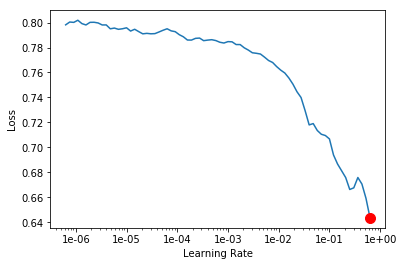

In [17]:
classifier.recorder.plot(suggestion=True)

In [10]:
gc.collect()

149

In [19]:
classifier.data.classes

['last', 'not_last']

In [20]:
classifier.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.374673,0.321665,0.861861,0.917702,1:23:49
1,0.377915,0.246630,0.919050,0.981627,1:55:47


## Fine Tuning
Our classifier did decently well after training with one epoch at a learning rate of 1e-3. We can save our trained model and freeze certain layers to fine tune to try to improve the model's accuracy.

### What is freezing?
When you freeze layers in fast.ai, you make the weights of earlier layer groups unchangeable. The point of this is to retain what the model has already learned about basic representations. The last few layer groups are left unfrozen so that they can learn representaitons specific to your tax.

In [21]:
classifier.save('schools1-preds-v3')

In [13]:
classifier.load('schools1-preds-v3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (51192 items)
x: TextList
xxbos xxunk xxmaj crown copyright xxunk xxmaj website xxunk xxmaj this document may be reproduced in whole or in part for non xxunk commercial educational purposes xxunk provided that information quoted is reproduced without adaptation and source and date of publication are stated xxunk xxmaj the xxunk xxmaj club for s provision xxmaj unique reference number xxup xxunk xxmaj inspect ion date xxunk xxunk xxunk xxunk xxunk xxmaj inspector xxmaj sarah xxmaj quinn xxmaj setting address xxmaj willaston xxmaj primary xxmaj school xxunk xxmaj derwent xxmaj close xxunk xxmaj willaston xxunk xxmaj nantwich xxunk xxmaj cheshe xxunk xxup xxunk xxup xxunk xxmaj telephone number xxunk xxunk xxmaj email xxmaj type of setting xxmaj childcare on non xxunk domestic premises xxunk xxmaj the xxunk xxmaj club xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj this was carried out under sections xxunk and xxunk of xxmaj childcare x

In [14]:
gc.collect()

0

## Evaluating a Model with an Imbalanced Dataset
Along with precision and recall, we can also make a confusion matrix to better understand how our model is doing. Our confusion matrix below was built with the validation set that we handed to our classifier in the beginning (which was in `test.csv`).

We can break down the visualization below by defining a few basic terms. For our examples, let's assume that our positive label is `not_last`. 
- **true positives (tp)**: Our model predicted that a sample was the positive label, and this prediction was correct. (tp=2276)
- **true negatives (tn)**: Our model predicted that a sample was not the positive label, and this prediction was correct. (tn=6)
- **false positives (fp)**: Our model predicted that a sample was the positive label, and this prediction was incorrect. (fp=157)
- **false negatives (fn)**: Our model predicted that a sample was not the positive label, and the prediction was incorrect. (fn=4)

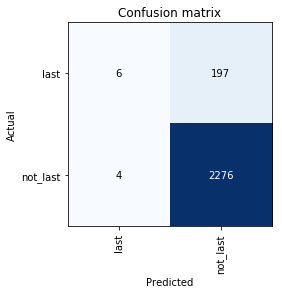

In [15]:
from fastai.vision import ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(classifier)
interp.plot_confusion_matrix()

In [16]:
classifier.export('export.pkl') # export our model so we can use it in production

## Checking the Precision of Our Model
As we said before, our dataset is imbalanced, so accuracy is not a good measure of our model's effectiveness. Precision refers to how close predictions from different samples are to each other. Below, we use `average_precision_score` from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). A single precision score is evaluated as `tp / (tp + fp)` where `tp` stands for *true positives* and `fp` stands for *false positives*. Average precision summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold. The increase in recall from the previous threshold is used as a weight. Recall measures the model's ability to find all relevant results that are correctly classified by your algorithm. Recall is the ratio `tp / (tp + fn)` where `tp` stands for *true positives* and `fn` stands for *false negatives*.

In [17]:
preds = classifier.get_preds()

In [18]:
not_last_preds = [p[1].item() for p in preds[0]]
last_preds = [p[0].item() for p in preds[0]]

In [19]:
preds[1]

tensor([1, 1, 1,  ..., 1, 1, 1])

In [20]:
from sklearn.metrics import average_precision_score
average_precision_score(preds[1],not_last_preds,average='weighted') 
# avg precision for not final 

0.9785737218376604

In [21]:
gc.collect()

1525

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(preds[1], 
                                         not_last_preds, pos_label = 1)
auc(fpr,tpr)
# ROC curve describes the ability of the classifier to distinguish two classes

0.8038263762855414

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5,0,'False Positive Rate')

Text(0,0.5,'True Positive Rate')

Text(0.5,1,'ROC Curve')

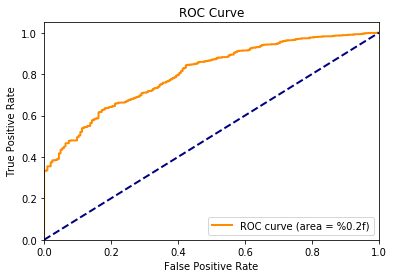

In [23]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Fine Tuning

In [24]:
classifier.freeze_to(-2)
classifier.fit(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.354988,0.269963,0.891663,0.941966,1:50:03
1,0.363576,0.255281,0.915828,0.969073,1:50:18
2,0.359049,0.279730,0.892871,0.943032,1:28:17
3,0.359793,0.248285,0.913008,0.965820,2:00:41


In [25]:
classifier.save('/picstorage/schools2-preds')

In [26]:
classifier.load('/picstorage/schools2-preds')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (51192 items)
x: TextList
xxbos xxunk xxmaj crown copyright xxunk xxmaj website xxunk xxmaj this document may be reproduced in whole or in part for non xxunk commercial educational purposes xxunk provided that information quoted is reproduced without adaptation and source and date of publication are stated xxunk xxmaj the xxunk xxmaj club for s provision xxmaj unique reference number xxup xxunk xxmaj inspect ion date xxunk xxunk xxunk xxunk xxunk xxmaj inspector xxmaj sarah xxmaj quinn xxmaj setting address xxmaj willaston xxmaj primary xxmaj school xxunk xxmaj derwent xxmaj close xxunk xxmaj willaston xxunk xxmaj nantwich xxunk xxmaj cheshe xxunk xxup xxunk xxup xxunk xxmaj telephone number xxunk xxunk xxmaj email xxmaj type of setting xxmaj childcare on non xxunk domestic premises xxunk xxmaj the xxunk xxmaj club xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj this was carried out under sections xxunk and xxunk of xxmaj childcare x

In [27]:
classifier.unfreeze()
classifier.fit(4, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.366580,0.262754,0.904954,0.955292,1:52:25
1,0.343879,0.269779,0.905356,0.955105,2:18:31
2,0.333291,1.855043,0.880789,0.930959,1:52:25
3,0.362128,0.273051,0.911398,0.963881,2:00:56


In [28]:
classifier.save('/picstorage/schools3-preds')

In [11]:
classifier.load('/picstorage/schools3-preds')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (51192 items)
x: TextList
xxbos xxunk xxmaj crown copyright xxunk xxmaj website xxunk xxmaj this document may be reproduced in whole or in part for non xxunk commercial educational purposes xxunk provided that information quoted is reproduced without adaptation and source and date of publication are stated xxunk xxmaj the xxunk xxmaj club for s provision xxmaj unique reference number xxup xxunk xxmaj inspect ion date xxunk xxunk xxunk xxunk xxunk xxmaj inspector xxmaj sarah xxmaj quinn xxmaj setting address xxmaj willaston xxmaj primary xxmaj school xxunk xxmaj derwent xxmaj close xxunk xxmaj willaston xxunk xxmaj nantwich xxunk xxmaj cheshe xxunk xxup xxunk xxup xxunk xxmaj telephone number xxunk xxunk xxmaj email xxmaj type of setting xxmaj childcare on non xxunk domestic premises xxunk xxmaj the xxunk xxmaj club xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj this was carried out under sections xxunk and xxunk of xxmaj childcare x

In [30]:
gc.collect()

0

## Trying a Few Test Samples
You can manually input a few test samples to see how your classifier is doing. I have included a few reports that were not included in our training set.

In [12]:
file = open('samples/last/2255481.txt','r').read()
classifier.predict(file) # should not be a final report

(Category not_last, tensor(1), tensor([0.2664, 0.7336]))

In [13]:
file2 = open('samples/last/50019386.txt','r').read() 
classifier.predict(file2) # Should not be a final report

(Category not_last, tensor(1), tensor([0.2485, 0.7515]))

In [14]:
file3 = open('samples/not_last/1410865.txt','r').read()
classifier.predict(file3) # Should not be a final report

(Category not_last, tensor(1), tensor([0.2387, 0.7613]))

In [15]:
file4 = open('samples/not_last/1593103.txt','r').read()
classifier.predict(file4) # Should not be a final report

(Category not_last, tensor(1), tensor([0.2953, 0.7047]))

## Better Understanding Your Model
Fast.ai also has a feature that allows you to see which words your classifier finds informative in making its prediction. The class that allows you to do this is [`TextClassificationInterpretation`](https://docs.fast.ai/text.learner.html#TextClassificationInterpretation). 

In [16]:
import matplotlib.cm as cm
classifier.model = classifier.model.module
txt_ci = TextClassificationInterpretation.from_learner(classifier)

In [17]:
txt_ci.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
xxbos xxup xxunk xxup inspection xxup report xxup bisham c of e xxup primary xxup school xxmaj bisham xxunk xxmaj marlow xxup lea area xxunk xxmaj royal xxmaj borough of xxmaj windsor and xxmaj maidenhead xxmaj unique reference number xxunk xxunk xxmaj headteacher xxunk xxmaj mr xxmaj jim xxmaj cooke xxmaj reporting inspector xxunk xxmaj margaret xxmaj dickinson xxunk xxmaj dates of xxunk xxunk xxunk xxunk xxmaj october xxunk xxmaj,not_last,not_last,10.62,1.00
xxbos xxmaj xxunk xxmaj xxunk xxmaj road xxunk xxmaj aylesbury xxunk xxmaj buckinghamshe xxunk xxup xxunk xxup xxunk xxmaj inspection dates xxunk xxmaj september xxunk xxmaj overall effectiveness xxmaj previous xxunk xxmaj outstanding xxunk xxmaj this xxunk xxmaj outstanding xxunk xxmaj achievement of xxmaj outstanding xxunk xxmaj quality of teaching xxmaj outstanding xxunk xxmaj behaviour and safety of xxmaj outstanding xxunk xxmaj leadership and management xxmaj outstanding xxunk xxmaj summary,not_last,last,9.32,0.00
xxbos xxup protect xxunk xxup xxunk xxmaj july xxunk xxmaj hulton xxmaj primary schoolschool xxunk xxunk xxunk on xxunk xxunk xxunk xxunk xxunk xxmaj hulton xxmaj primary xxmaj school xxunk xxunk interim assessment i am pleased to provide some important information about xxmaj abbey xxmaj hulton xxmaj primary xxmaj school xxunk xxmaj as you may know xxunk during its last in xxmaj november xxunk xxunk inspectors judged your child xxunk,last,not_last,8.24,0.00
xxbos xxunk xxmaj palmer xxunk xxmaj reference xxunk xxunk xxunk xxmaj march xxunk xxunk xxunk inspectorthis of was carried out under section 5 of xxmaj education xxmaj act xxunk streetschool addressprimarytype of xxunk xxunk xxunk range of xxunk xxunk xxunk numbermixedgender of xxunk xxunk xxunk xxunk on roll xxunk xxunk xxmaj celia xxunk erning bodyappropriate xxunk xxunk xxmaj october xxunk of previous xxmaj inspection numberinspection datesage xxunk xxmaj march xxunk,last,not_last,7.20,0.00
xxbos xxmaj school report xxmaj aeville xxmaj school xxmaj gargrave xxmaj road xxunk xxmaj skipton xxunk xxmaj north xxmaj yorkshe xxunk xxup xxunk xxup xxunk xxmaj inspection dates xxunk xxmaj may xxunk xxmaj overall effectiveness xxmaj previous xxunk xxmaj satisfactory xxunk xxmaj this xxunk xxmaj inadequate 4 xxmaj achievement of xxmaj inadequate 4 xxmaj quality of teaching xxmaj inadequate 4 xxmaj behaviour and safety of xxmaj good xxunk xxmaj leadership,last,not_last,7.05,0.00
xxbos xxunk xxunk xxunk xxunk xxunk xxmaj dear xxmaj parent xxmaj xxunk xxmaj primary xxmaj school xxunk xxunk interim assessment xxunk i am pleased to provide some important information about xxmaj xxunk xxmaj primary xxmaj school xxunk xxmaj as you may know xxunk during its last in xxmaj xxunk xxunk inspectors judged your child xxunk to be xxunk xxmaj schools which are performing well are now inspected less often than,last,not_last,6.94,0.00
xxbos xxmaj age group xxunk xxmaj inspection xxunk xxunk xxunk xxmaj december xxunk xxmaj inspection number xxunk xxmaj all xxmaj saints c of e xxunk c xxunk xxmaj fst xxmaj school xxmaj unique xxmaj reference xxmaj number xxunk xxmaj local xxmaj authority xxmaj staffordshe xxmaj inspect ion number xxunk xxmaj inspect ion dates xxunk xxmaj december xxunk xxmaj report ing inspector xxmaj andrew xxmaj stafford xxmaj type of xxmaj fst,last,not_last,6.55,0.00
xxbos xxmaj school report xxmaj east xxmaj xxunk xxmaj junior xxmaj school xxmaj north xxmaj lane xxunk xxmaj east xxmaj xxunk xxunk xxup xxunk xxup xxunk xxmaj inspection dates xxunk xxunk xxunk xxmaj september xxunk xxmaj overall effectiveness xxmaj previous xxunk xxmaj good xxunk xxmaj this xxunk xxmaj good xxunk xxmaj achievement of xxmaj good xxunk xxmaj quality of teaching xxmaj good xxunk xxmaj behaviour and safety of xxmaj outstanding,last,not_last,5.85,0.00
xxbos xxmaj al xxunk xxmaj xxunk xxmaj islamic xxmaj school xxmaj independent progress monitoring report dfe registration number xxunk xxunk 

In [18]:
txt_ci.show_intrinsic_attention(file,cmap=cm.Purples)

In [19]:
txt_ci.show_intrinsic_attention(file2,cmap=cm.Purples)

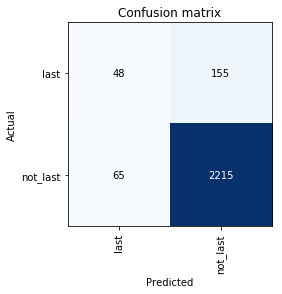

In [20]:
from fastai.vision import ClassificationInterpretation
interp2 = ClassificationInterpretation.from_learner(classifier)
interp2.plot_confusion_matrix()

In [21]:
tmp = test[test.label == 'last'] # Separate last reports to see how they're performing

In [22]:
tmp.head()

,school,file,date,status,text,label,address
1666,24 Seven Fostering Services Closed,2593566,2016-08-01,closed,": 24 Seven Fostering Services, 01/08/2016 1 o...",last,"Churchill Business Centre, Ground Floor, Unit ..."
1674,Abacus Pre-School Playgroup Closed,2613029,2016-11-01,closed,Abacus Pre-School Playgroup Frank Halfp...,last,"Frank Halfpenny Hall, George Lane, Lichfield, ..."
1675,Abbey 345 Pre-School Closed,1626315,2004-07-09,closed,DAY CARE INSPECTION REPORTURN EY231881INSPECTI...,last,"St. Guthlac School, Postland Road, Crowland, P..."
1687,Abbeyjacks Community Pre-school Limited Closed,2517419,2015-10-09,closed,Abbeyjacks Community Pre- Limited The A...,last,"The Abbey, Market Square, Daventry, Northants,..."
1688,Abbeywood First School Closed,2377825,2014-03-28,closed,28 April 2014 Dear Parent Abb...,last,"Wood Piece Lane, Church Hill, Redditch, Worces..."


In [23]:
classifier.export('export2.pkl')

In [29]:
idx1 = 1666
print(classifier.predict(str(classifier.data.valid_ds.x[idx1])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx1],cmap=cm.Purples)

(Category not_last, tensor(1), tensor([0.1763, 0.8237]))


In [28]:
idx2 = 1688
print(classifier.predict(str(classifier.data.valid_ds.x[idx2])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx2],cmap=cm.Purples)

(Category not_last, tensor(1), tensor([0.0689, 0.9311]))


idx2 = 46
print(classifier.predict(str(classifier.data.valid_ds.x[idx2])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx2],cmap=cm.Purples)

In [25]:
idx3 = 1674
print(classifier.predict(str(classifier.data.valid_ds.x[idx3])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx3],cmap=cm.Purples)

(Category not_last, tensor(1), tensor([0.4556, 0.5444]))


In [26]:
idx4 = 1675
print(classifier.predict(str(classifier.data.valid_ds.x[idx4])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx4],cmap=cm.Purples)

(Category not_last, tensor(1), tensor([0.0712, 0.9288]))


In [27]:
idx5 = 1687
print(classifier.predict(str(classifier.data.valid_ds.x[idx5])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx5],cmap=cm.Purples)

(Category not_last, tensor(1), tensor([0.1728, 0.8272]))


In [31]:
test[test.text.str.contains('outstanding')]

,school,file,date,status,text,label,address
0,115 Club Ringwood,2486667,2015-05-22,open,115 Club Ringwood Ringwood County Junio...,not_last,"Ringwood County Junior School, Hightown Road, ..."
2,1st Steps Preschool,2563277,2016-04-11,open,"1st Steps Pre ST BARNABAS PARISH HALL, ...",not_last,"St. Barnabas Parish Hall, 3 De Trafford Street..."
3,2 Sisters Premier Division Ltd,870855,2002-07-04,open,Premier Fresh Foods LtdINSPECTION REPORT02 Jul...,not_last,"Ram Boulevard, FoxHills Industrial Estate, Scu..."
4,2Schools Consortium,940859,2009-06-08,open,2 Schools ConsortiumInitial Teacher Education ...,not_last,"Oakthorpe Primary School, Tile Kiln Lane, Palm..."
5,3 Dimensions,2141279,2012-03-13,open,3 Dimensions School Independent standard re...,not_last,"Chardleigh House, Chardleigh Green, Wadeford, ..."
7,3-2-5 Pre-School,1788501,2011-05-20,open,3-2-5 Pre for s...,not_last,"Burghclere Down Community Centre, Berry Way, A..."
13,Chapel-en-le-Frith CofE VC Primary School,906999,2008-11-19,open,UntitledChapel-en-le-Frith CofE VC PrimaryScho...,not_last,"Warmbrook Road, Chapel-En-le-Frith, High Peak,..."
15,Chapmanslade Church of England Voluntary Aided...,854521,2007-01-18,open,UntitledChapmanslade Church of England Volunta...,not_last,"High Street, Chapmanslade, Westbury, Wiltshire..."
20,Charles Darwin School,2289489,2013-10-24,open,School report Charles Darwin School Jail La...,not_last,"Jail Lane, Biggin Hill, Westerham, Kent, TN16 3AU"
21,Charles Darwin School,1904765,2012-02-14,open,Existing academy: Charles Darwin School URN...,not_last,"Jail Lane, Biggin Hill, Westerham, Kent, TN16 3AU"


In [33]:
test.loc[7]['text'] # this is an outstanding school

"                              3-2-5 Pre  for s provision   Unique reference number  EY285836 Inspect ion date 20/05/2011 Inspector Carine Sample   Setting address Burghclere Down Community Centre, Berry Way, Andover, Hampshe, SP10 3RZ Telephone number  07944 220 280 Email belcher.sarah@vgin.net Type of setting Childcare on non-domestic premises   : 3-2-5 Pre, 20/05/2011    2                            The Office for Standards in Education, Children's Services and Skills () regulates and inspects to achieve excellence in  care of  and young people, and in education and skills for learners of all ages. It regulates and inspects childcare and 's social care, and inspects  Children and Family Court Advisory Support Service (Cafcass), , colleges, initial teacher training, work-based  and skills training, adult and community , and education and training in prisons and or secure establishments. It assesses council ’s services, and inspects services for looked after , safeguarding and child p

In [34]:
idx6 = 7
print(classifier.predict(str(classifier.data.valid_ds.x[idx6])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx6],cmap=cm.Purples)

(Category not_last, tensor(1), tensor([0.1669, 0.8331]))


In [36]:
preds = classifier.get_preds(ordered=True)

In [37]:
classifier.data.classes

['last', 'not_last']

In [38]:
not_last_preds = [p[1].item() for p in preds[0]]
last_preds = [p[0].item() for p in preds[0]]

In [39]:
from sklearn.metrics import average_precision_score
average_precision_score(preds[1],not_last_preds,average='weighted') 
# avg precision for not final 

0.9777174524730128

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(preds[1], 
                                         not_last_preds, pos_label = 1)
auc(fpr,tpr)
# ROC curve describes the ability of the classifier 
# to distinguish two classes

0.8216597528303518

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5,0,'False Positive Rate')

Text(0,0.5,'True Positive Rate')

Text(0.5,1,'ROC Curve')

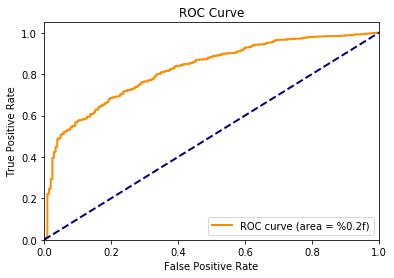

In [41]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [42]:
test.head()

,school,file,date,status,text,label,address
0,115 Club Ringwood,2486667,2015-05-22,open,115 Club Ringwood Ringwood County Junio...,not_last,"Ringwood County Junior School, Hightown Road, ..."
1,115 Club St Walburga's,2019505,2012-05-29,open,115 Club St Walb...,not_last,"St. Walburga's Catholic Primary School, Malver..."
2,1st Steps Preschool,2563277,2016-04-11,open,"1st Steps Pre ST BARNABAS PARISH HALL, ...",not_last,"St. Barnabas Parish Hall, 3 De Trafford Street..."
3,2 Sisters Premier Division Ltd,870855,2002-07-04,open,Premier Fresh Foods LtdINSPECTION REPORT02 Jul...,not_last,"Ram Boulevard, FoxHills Industrial Estate, Scu..."
4,2Schools Consortium,940859,2009-06-08,open,2 Schools ConsortiumInitial Teacher Education ...,not_last,"Oakthorpe Primary School, Tile Kiln Lane, Palm..."


## Taking a look at some of the reports that were classified as `last`

In [62]:
# Get all of the items that our classifier predicted as 'last' in our valid set
classes = preds[1]
idx = []
for i in range(len(classes)):
    last = preds[0][i][0].item()
    not_last = preds[0][i][1].item()
    if last > not_last:
        idx.append(i)
print (idx)

[2, 34, 49, 55, 102, 171, 185, 202, 210, 212, 223, 224, 265, 277, 343, 345, 417, 422, 437, 440, 441, 499, 529, 612, 617, 649, 653, 655, 740, 924, 964, 993, 994, 1145, 1166, 1203, 1226, 1236, 1287, 1306, 1396, 1441, 1471, 1489, 1511, 1512, 1550, 1583, 1587, 1616, 1674, 1693, 1707, 1708, 1720, 1746, 1752, 1754, 1759, 1770, 1774, 1782, 1842, 1852, 1856, 1892, 1897, 1900, 1915, 1932, 1939, 1958, 1961, 1968, 1991, 2001, 2013, 2018, 2026, 2046, 2052, 2083, 2119, 2150, 2154, 2175, 2208, 2210, 2223, 2230, 2239, 2240, 2246, 2251, 2253, 2256, 2270, 2272, 2302, 2315, 2330, 2348, 2392, 2397, 2403, 2405, 2408, 2420, 2444, 2448, 2458, 2460, 2466]


In [63]:
test.loc[2]['text']

"    1st Steps Pre    ST BARNABAS PARISH HALL, DE TRAFORD STREET, CROSLAND MOOR, HD4 5DR      Inspection date Previous  date 11 April 2016  Not applicable  The quality and standards of  s provision This : Good  2   Previous : Not applicable   Effectiveness of  leadership and management Good  2 Quality of teaching,  and assessment Good 2 Personal development, behaviour and welfare Good 2  Outcomes for  Good  2  Summary of key findings for parents  This provision is      \uf06e Children make  progress and enjoy  wide variety of activities and resources available. Staff observe  as y play and make accurate assessments of what y know and can do. They use this knowledge to inform future planning so that each child can be challenged to move to  next stage in  .   \uf06e The well established, key-person system helps  to form strong emotional attachments. Children develop high levels of confidence and feel safe and secure in  pre- envonment.   \uf06e Staff work closely with parents to help m m

In [64]:
idx7 = 2 # not_last but predicted as last
print(classifier.predict(str(classifier.data.valid_ds.x[idx7])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx7],cmap=cm.Purples)

(Category last, tensor(0), tensor([0.5341, 0.4659]))


In [65]:
idx8 = 34 # not_last but predicted as last
print(classifier.predict(str(classifier.data.valid_ds.x[idx8])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx8],cmap=cm.Purples)

(Category last, tensor(0), tensor([0.5342, 0.4658]))


In [66]:
test.loc[1770]

school                     Airmyn Park Primary School Closed
file                                                 2744637
date                                              2017-11-28
status                                                closed
text            Piccadilly Gate Store Street Manchester M...
label                                                   last
address                 Percy Drive, Airmyn, Goole, DN14 8NZ
Name: 1770, dtype: object

In [68]:
idx9 = 1770
print(classifier.predict(str(classifier.data.valid_ds.x[idx9])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx9],cmap=cm.Purples)

(Category last, tensor(0), tensor([9.9916e-01, 8.3952e-04]))


In [69]:
test.loc[1770]['text']

'     Piccadilly Gate Store Street Manchester M1 2WD   T 0300 123 4234        8 December 2017  Mrs Heidi Whyley Headteacher  Amyn Park Primary School Percy Drive Amyn Goole DN14 8NZ  Dear Mrs Whyley  Short  of Amyn Park Primary School  Following my visit to   on 28 November 2017, I write on behalf of Her Majesty’s Chief Inspector of Education, Children’s Services and Skills to report   findings. The visit was  fst short  carried out since   was judged to be  in July 2013.  This  continues to be .  The leadership team has maintained   quality of education in   since  last . You have successfully managed a period of considerable change in ing and ernance over  last few years and have developed a team that is committed to collectively taking responsibility for improving ’ outcomes. Staff are taking greater ownership of  professional development and are motivated to support  improvement in  areas of responsibility, many of which are new to m.   You are passionate about providing  with a wi